In [1]:
from src.mapping import compute_area_scores

from src.plotter import plot_comparison, plot_delta_vs_baseline

from src.alex_extractor import build_alexnet_design_matrices_with_dataloader

import itertools
import pandas as pd
import json
import matplotlib.pyplot as plt
import os

from itertools import product
from pathlib import Path
import pickle
from tqdm import tqdm

# Signals

## Model (Alexnet)

Producing the Alexnet activations for all the stimuli of the Allen dataset, for all the trained model and the untrained one

In [2]:
# Common params once
COMMON = dict(
    folder="../allen-data-clean/stimuli_images/",
    batch_size=16,
    shuffle=False,
    num_workers=4,
    device="cpu",
    amp=True,
    layers_keep=["conv1","conv2","conv3","conv4","conv5"],
    return_in_memory=False,  # keeps memmaps on disk (good for many models)
)

# Built-ins
weight_specs = [
    ("Random",   "random"),
    ("ImageNet", "imagenet"),
]

# # Add all local .pth/.pt in a directory (adjust path!)
ckpt_dir = Path("../models/weights/") 
for p in sorted(ckpt_dir.glob("*.pth")) + sorted(ckpt_dir.glob("*.pt")):
    label = p.stem  # nice display name
    # You can pass a str path because of the patch above:
    weight_specs.append((label, str(p)))

diet_opts = ["diet", "no-diet", "random-diet", "nayebi-diet"] # diet options at inference time 

def make_save_dir(label: str, diet: bool) -> str:
    base = f"{label.lower().replace(' ', '-')}"
    return f"{base}-{diet}-act" 

index_models = {}
for (label, weights), diet in product(weight_specs, diet_opts):
    tag = f"{label}-{diet}"
    save_dir = make_save_dir(label, diet)
    index_models[tag] = build_alexnet_design_matrices_with_dataloader(
        **COMMON,
        weights=weights,  # "random" | "imagenet" | "/path/to.ckpt" (string) | {"file": "..."}
        diet=diet,
        save_dir=Path("activation") / save_dir,
    )


/home/giovanni/Desktop/mice-representation/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/giovanni/Desktop/mice-representation/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[load] Dropped 2 mismatched keys. Examples: ['classifier.6.weight', 'classifier.6.bias']
[load] Dropped 2 mismatched keys. Examples: ['classifier.6.weight', 'classifier.6.bias']
[load] Dropped 2 mismatched keys. Examples: ['classifier.6.weight', 'classifier.6.bias']
[load] Dropped 2 mismatched keys. Examples: ['classifier.6.weight', 'classifier.6.bias']


## Loading Neural Data

In [5]:
# # load the index containing the neural data
index_df = pd.read_csv('../allen-data-clean/PreprocData/index.csv')

# RSA

In [ ]:
# layer_scores_rsa = {}
# median_scores_rsa = {}

# # Wrap the loop with tqdm
# for name, idx in tqdm(index_models.items(), desc="Computing area scores", total=len(index_models)):
#     layers, median = compute_area_scores(idx, index_df, sim_metric="RSA")
#     layer_scores_rsa[name] = layers
#     median_scores_rsa[name] = median

In [5]:
# with open("rsa_results.pkl", "wb") as f:
#     pickle.dump({
#         "layer_scores": layer_scores_rsa,
#         "median_scores": median_scores_rsa
#     }, f)

In [2]:
# load the pkl dictionaries with results

with open("rsa_results.pkl", "rb") as f:
    results = pickle.load(f)

layer_scores_rsa = results["layer_scores"]
median_scores_rsa = results["median_scores"]

In [3]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    # "Rand-Id" : median_scores_rsa["Random-diet"],
    # "Rand-Ir" : median_scores_rsa["Random-random-diet"],
    # "Rand-Iny" : median_scores_rsa["Random-nayebi-diet"],

    "INet-In" : median_scores_rsa["ImageNet-no-diet"],
    # "INet-Id" : median_scores_rsa["ImageNet-diet"],
    # "INet-Ir" : median_scores_rsa["ImageNet-random-diet"],
    # "INet-Iny" : median_scores_rsa["ImageNet-nayebi-diet"],

    # "INet-Td-In" : median_scores_rsa["inet-td-no-diet"],
    "INet-Td-Id" : median_scores_rsa["inet-td-diet"],
    # "INet-Td-Ir" : median_scores_rsa["inet-td-random-diet"],
    # "INet-Td-Iny" : median_scores_rsa["inet-td-nayebi-diet"],

    # "FT-In" : median_scores_rsa["finetune-no-diet"],
    # "FT-Id" : median_scores_rsa["finetune-diet"],
    # "FT-Ir" : median_scores_rsa["finetune-random-diet"],
    # "FT-Iny" : median_scores_rsa["finetune-nayebi-diet"],
}

/home/giovanni/Desktop/mice-representation/neural-mapping/src/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)
/home/giovanni/Desktop/mice-representation/neural-mapping/src/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)
/home/giovanni/Desktop/mice-representation/neural-mapping/src/plotter.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(layer_order, rotation=0)


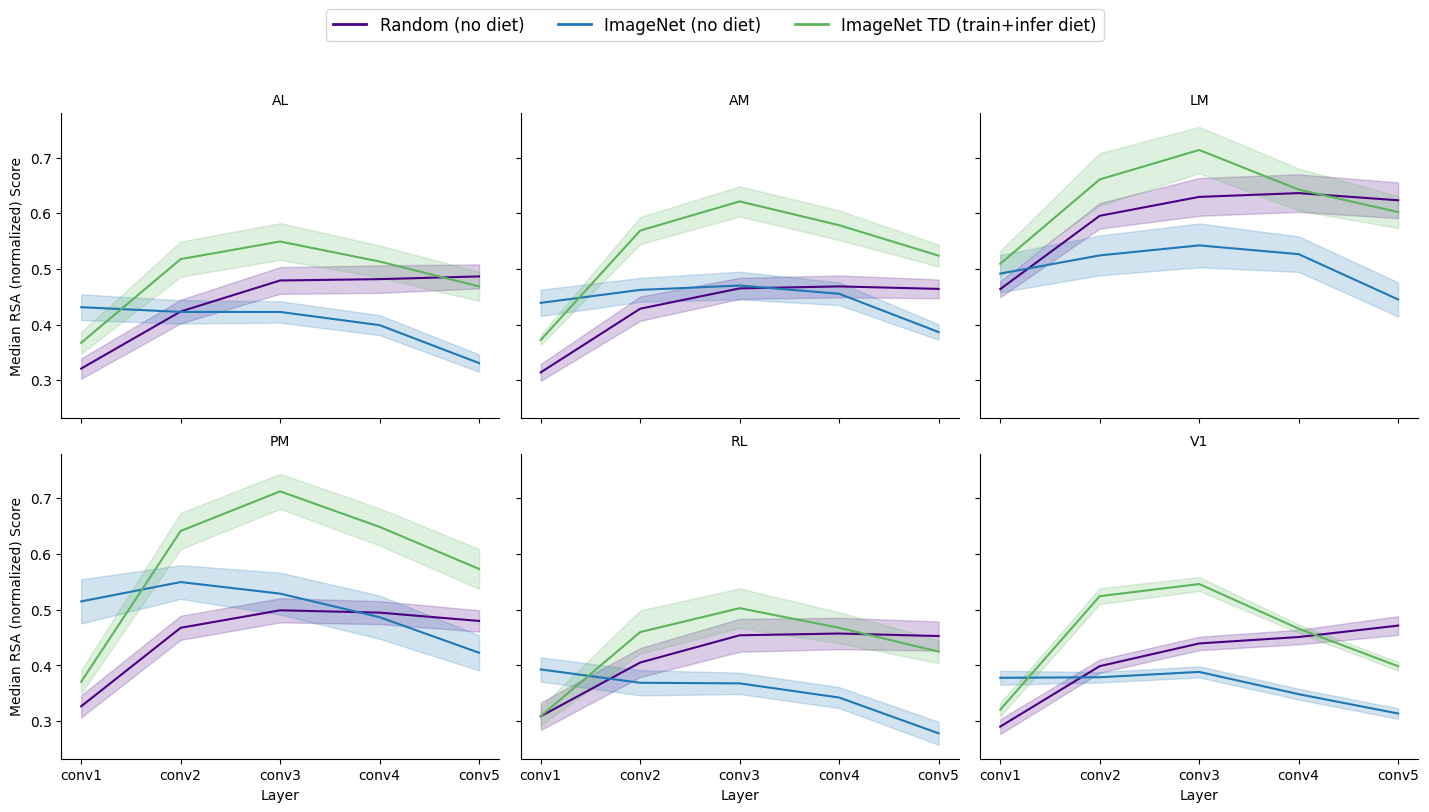

In [4]:
# fattori di normalizzazione per area
area_norm = pd.Series({
    "AL":    0.647716,
    "AM":    0.570069,
    "LM":    0.453128,
    "PM":    0.551936,
    "RL":    0.542426,
    "V1":    0.592209
}, name="norm_factor")

def normalize_scores_by_area(scores_dict, *, normalize_sem=True):
    """scores_dict: dict[str, pd.DataFrame] con colonne ['area','layer','score','sem']"""
    out = {}
    for model_name, df in scores_dict.items():
        df2 = df.copy()
        # aggiunge il fattore per area
        df2 = df2.merge(area_norm, left_on="area", right_index=True, how="left")
        if df2["norm_factor"].isna().any():
            missing = df2.loc[df2["norm_factor"].isna(), "area"].unique().tolist()
            raise ValueError(f"Manca il fattore per queste aree: {missing}")
        # normalizza
        df2["score"] = df2["score"] / df2["norm_factor"]
        if normalize_sem and "sem" in df2.columns:
            df2["sem"] = df2["sem"] / df2["norm_factor"]
        # pulizia
        df2 = df2.drop(columns=["norm_factor"])
        out[model_name] = df2
    return out

# usa la funzione sul tuo dizionario
scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

plot_comparison(scores_to_plot_rsa_norm, metric_name="RSA (normalized)")


In [5]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    "INet-In" : median_scores_rsa["ImageNet-no-diet"],
    "INet-Id" : median_scores_rsa["ImageNet-diet"],
    # "INet-Iny" : median_scores_rsa["ImageNet-nayebi-diet"],
    "INet-Td-In" : median_scores_rsa["inet-td-no-diet"],
    "INet-Td-Id" : median_scores_rsa["inet-td-diet"],
    # "FT-Id" : median_scores_rsa["finetune-diet"],
}

scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

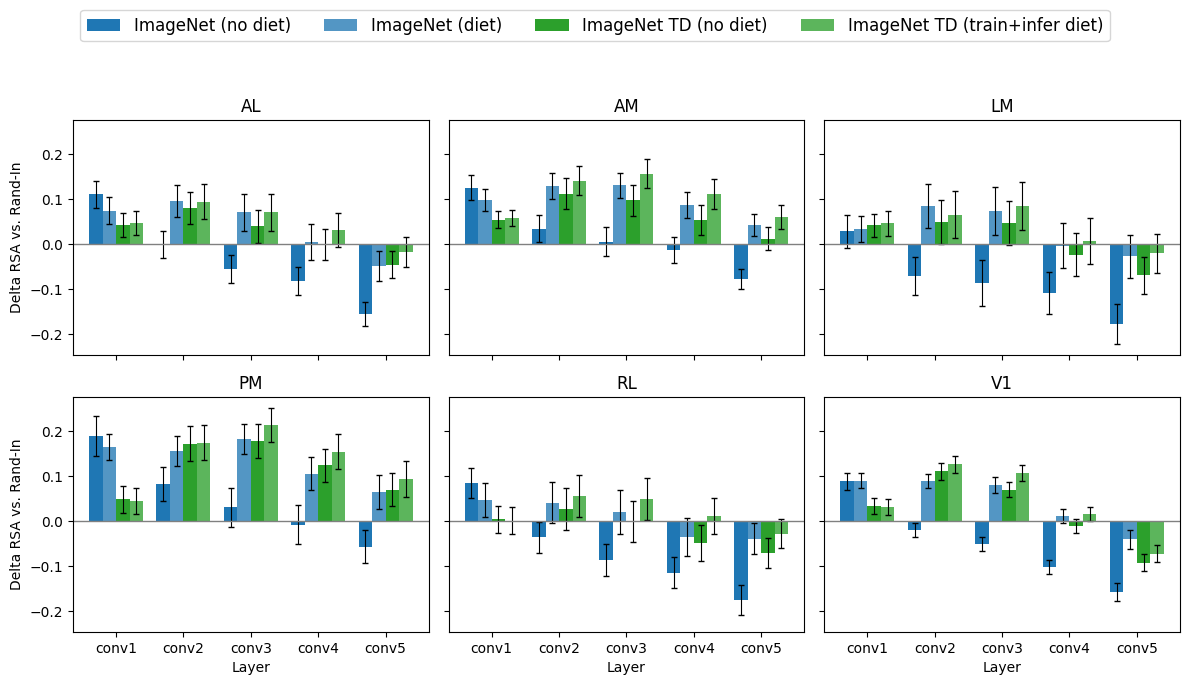

In [6]:
fig, axes = plot_delta_vs_baseline(scores_to_plot_rsa_norm)

# Show interactively
plt.show()

# OR save it to file
fig.savefig("../report/image/inference.jpeg", dpi=300, bbox_inches="tight")

## Diet impact over Random

In [8]:
scores_to_plot_rsa = {
    "Rand-In" : median_scores_rsa["Random-no-diet"],
    "Rand-Id" : median_scores_rsa["Random-diet"],
    "Rand-Iny" : median_scores_rsa["Random-nayebi-diet"],
    "Rand-Ir" : median_scores_rsa["Random-random-diet"],
}

scores_to_plot_rsa_norm = normalize_scores_by_area(scores_to_plot_rsa, normalize_sem=True)

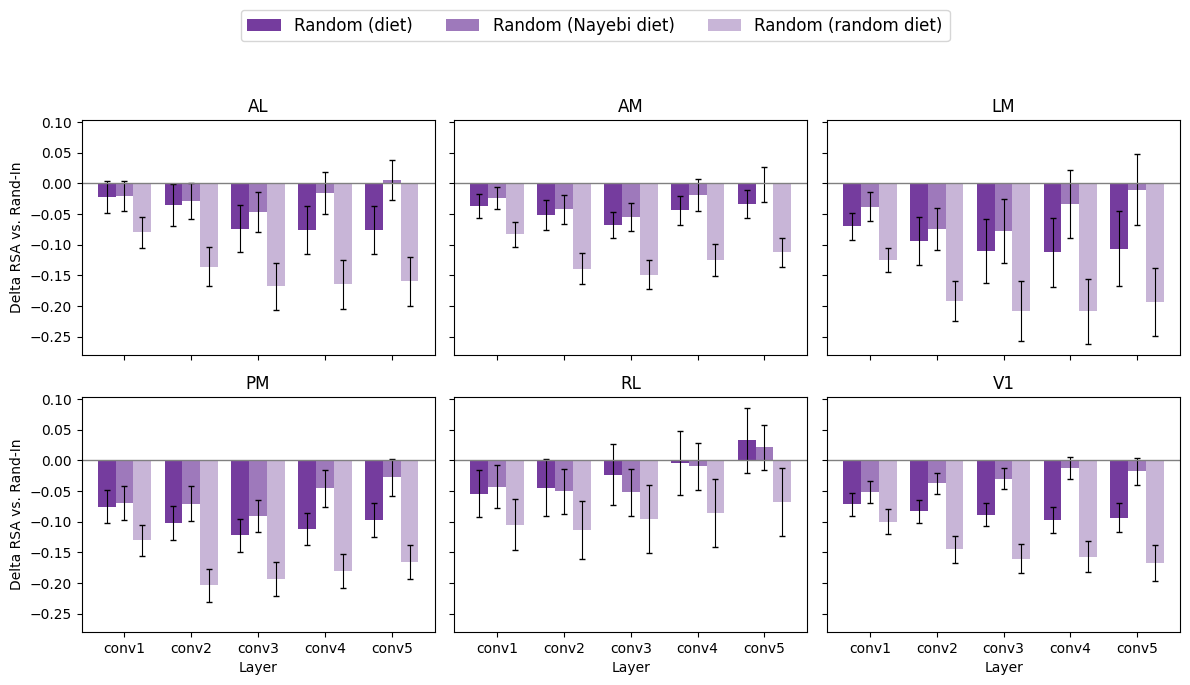

In [9]:
plot_delta_vs_baseline(scores_to_plot_rsa_norm)